In [178]:
## Autograd
import autograd.numpy as np
from autograd.numpy.random import seed, randn, rand
from autograd.numpy import exp, hstack, log
from autograd import grad, jacobian
from autograd.numpy.linalg import norm
from autograd.scipy.stats import norm as ag_norm
from autograd.extend import primitive, defvjp
from autograd.numpy.numpy_vjps import unbroadcast_f

# Standard Python Imports
from scipy.stats import norm as ndist
from scipy.stats import uniform as udist
from numpy import zeros, eye, vstack
from scipy.stats import multivariate_normal as MVN
from numpy.random import uniform
from scipy.optimize import fsolve
from statsmodels.tsa.stattools import acf

# Custom functions
from tangential_hug_functions import HugTangentialStepEJSD_Deterministic, Hop_Deterministic, HugStepEJSD_Deterministic, HugRotatedStepEJSD_AR_Deterministic, HugRotatedStepEJSD_Deterministic
from utils import ESS_univariate, ESS, n_unique

import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [2]:
def f(thetau):
    """Deterministic function for distance manifold. f:R^5 -> R """
    a_param, b_param, k_param, *z = thetau  # Latents are standard normal variables
    z = np.array(z)
    out = a_param + b_param*(1 + 0.8 * (1 - exp(-g_param * z)) / (1+exp(-g_param * z))) * ((1 + z**2)**k_param) * z
    return norm(out - y_star)

In [3]:
def data_generator(theta, N=2):
    """Generates initial observed data y_star."""
    z = randn(N)         # Get N samples from N(0, 1) for G&K simulation.
    a_param, b_param, k_param = theta   # Grab parameters
    return a_param + b_param*(1 + 0.8 * (1 - exp(-g_param * z)) / (1+exp(-g_param * z))) * ((1 + z**2)**k_param) * z

In [4]:
theta0 = np.array([3.0, 1.0, 0.5])
g_param = 2.0
y_star = data_generator(theta0, N=2)

In [5]:
grad_function = grad(f)

In [6]:
def logprior(thetau):
    """Log prior distribution."""
    with np.errstate(divide='ignore'):
        return log((abs(thetau[:3]) <= 10).all().astype('float64')) + ndist.logpdf(thetau[-2:]).sum()
    
def log_uniform_kernel(xi, epsilon):
    """Log density of uniform kernel. """
    with np.errstate(divide='ignore'):
        return log((f(xi) <= epsilon).astype('float64'))
    
def log_abc_posterior(xi):
    """Log density of ABC posterior. Product of (param-latent) prior and uniform kernel."""
    return logprior(xi) + log_uniform_kernel(xi, epsilon)

In [204]:
def experiment(x00, T, N, alphas, nlags):
    """Runs Hug+Hop and RotatedHUG+HOP using the same velocities and the same random seeds.
    We also try to limit the noise in the HOP kernel by sampling the u variables beforehand.
    I run RotatedHUG for all values of alpha with the randomness fixed. 
    This is 1 run, for 1 epsilon. It does 1 HUG+HOP and then THUG+HOP for all alphas.
    T1: T for HUG
    T2: T for RotatedHUG
    """
    ### COMMON VARIABLES
    v = q.rvs(N)
    log_uniforms1 = log(rand(N))     # Log uniforms for the HUG kernels
    log_uniforms2 = log(rand(N))     # Log uniforms for the HOP kernel
    u = MVN(zeros(5), eye(5)).rvs(N) # Original velocities for HOP kernel
    ### STORAGE (HUG + HOP)
    hh = x00              # Initial sample
    ahh1 = 0.0            # Acceptance probability for HUG kernel
    ahh2 = 0.0            # Acceptance probability for HOP kernel (when used with HUG)
    ehh = 0.0             # EJSD
    eghh = 0.0            # EJSD in Gradient direction
    ethh = 0.0            # EJSD in Tangent direction
    ### STORAGE (RotatedHUG + HOP) I MUST STORE FOR ALL ALPHAS
    arh1 = zeros(n_alphas)
    arh2 = zeros(n_alphas)
    erh  = zeros(n_alphas)
    egrh = zeros(n_alphas)
    etrh = zeros(n_alphas)
    ### ADDITIONAL STORAGE FOR RotatedHUG
    rh_esst = zeros(n_alphas)
    rh_essu = zeros(n_alphas)
    rh_essj = zeros(n_alphas)
    rh_uniq = zeros(n_alphas)
    rh_act  = zeros((n_alphas, nlags))
    rh_acu  = zeros((n_alphas, nlags))
    ### HUG + HOP
    x = x00
    for i in range(N):
        y, a1, e, eg, et = HugStepEJSD_Deterministic(x, v[i], log_uniforms1[i], T, B, q, log_abc_posterior, grad_function)
        x, a2 = Hop_Deterministic(y, u[i], log_uniforms2[i], lam, kappa, log_abc_posterior, grad_function)
        hh = vstack((hh, y, x))
        ahh1 += a1 * 100 / N
        ahh2 += a2 * 100 / N
        ehh += e / N
        eghh += eg / N 
        ethh += et / N 
    # COMPUTE ESS AND OTHER METRICS FOR HUG
    hh = hh[1:]
    hh_esst = ESS_univariate(hh[::2, 0])     # ESS for theta
    hh_essu = ESS_univariate(hh[::2, 1])     # ESS for u
    hh_essj = ESS(hh[::2])                   # ESS joint
    hh_uniq = n_unique(hh)                             # Number of unique samples
    hh_act  = acf(hh[::2, 0], adjusted=True, nlags=nlags, fft=True)[1:]  # Autocorrelation for theta (remove the first 1.0)
    hh_acu  = acf(hh[::2, 1], adjusted=True, nlags=nlags, fft=True)[1:]  # Autocorrelation for u
    ### RotatedHUG + HOP
    for k, alpha in enumerate(alphas):
        x = x00
        rh = x00      # RESTART THE SAMPLES FROM SCRATCH
        for i in range(N):
            y, a1, e, eg, et = HugRotatedStepEJSD_Deterministic(x, v[i], log_uniforms1[i], T, B, alpha, q, log_abc_posterior, grad_function)
            x, a2 = Hop_Deterministic(y, u[i], log_uniforms2[i], lam, kappa, log_abc_posterior, grad_function)
            rh = vstack((rh, y, x))
            arh1[k] += a1 * 100 / N
            arh2[k] += a2 * 100 / N
            erh[k]  += e / N
            egrh[k] += eg / N 
            etrh[k] += et / N 
        ### COMPUTE ESS AND OTHER METRISC FOR RotatedHUG
        rh = rh[1:]
        rh_esst[k] = ESS_univariate(rh[::2, 0])     # ESS for theta
        rh_essu[k] = ESS_univariate(rh[::2, 1])     # ESS for u
        rh_essj[k] = ESS(rh[::2])                   # ESS joint
        rh_uniq[k] = n_unique(rh)                             # Number of unique samples
        rh_act[k] = acf(rh[::2, 0], adjusted=True, nlags=nlags, fft=True)[1:]  # Autocorrelation for theta
        rh_acu[k] = acf(rh[::2, 1], adjusted=True, nlags=nlags, fft=True)[1:]  # Autocorrelation for u
    # RETURN EVERYTHING
    out = {
        'HH': {
            'A1': ahh1,
            'A2': ahh2,
            'E': ehh,
            'EG': eghh, 
            'ET': ethh,
            'ESS_T': hh_esst,
            'ESS_U': hh_essu,
            'ESS_J': hh_essj,
            'UNIQUE': hh_uniq,
            'AC_T': hh_act,
            'AC_U': hh_acu,
            'SAMPLES': hh
        },
        'RH': {
            'A1': arh1,
            'A2': arh2,
            'E': erh,
            'EG': egrh, 
            'ET': etrh, 
            'ESS_T': rh_esst,
            'ESS_U': rh_essu,
            'ESS_J': rh_essj,
            'UNIQUE': rh_uniq,
            'AC_T': rh_act,
            'AC_U': rh_acu,
            'SAMPLES': rh
        }
    }
    return out


In [205]:
q = MVN(zeros(5), eye(5))

In [232]:
alphas = [0.9]
n_alphas = len(alphas)
epsilon = 0.1
lam = epsilon / 15
kappa = 0.01
T1 = T2 = 0.3
B = 5
N = 50000
nlags = 20

In [233]:
# Start with a guess
guess = np.array([1.0, 1.0, 1.0, 0.0, 0.0]) 

# Find point on manifold using optimization
func = lambda xi: np.r_[f(xi), 0.0, 0.0, 0.0, 0.0]  # Append 0, 0 to make fsolve work.
xi0 = fsolve(func, guess)

In [234]:
out = experiment(xi0, T1, N, alphas, 20)

In [235]:
out['HH']['A1'], out['HH']['A2'], out['HH']['E'], out['HH']['ESS_J'] / N

(57.06200000002377,
 85.57999999998195,
 0.1414121938620494,
 0.007585646297959384)

In [236]:
out['RH']['A1'], out['RH']['A2'], out['RH']['E'], out['RH']['ESS_J'] / N

(array([35.498]), array([84.838]), array([0.11503711]), array([0.00606851]))

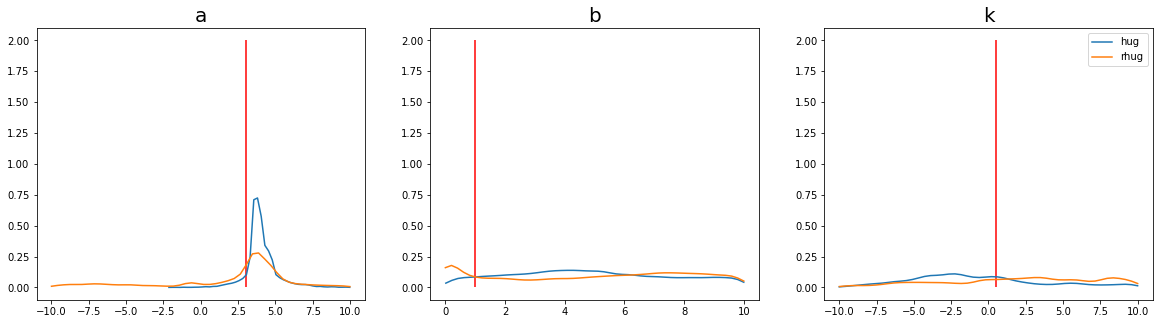

In [237]:
# HUG KDES
akde_hug = gaussian_kde(out['HH']['SAMPLES'][:, 0])
bkde_hug = gaussian_kde(out['HH']['SAMPLES'][:, 1])
kkde_hug = gaussian_kde(out['HH']['SAMPLES'][:, 2])
# HUG linspaces
xa_hug = np.linspace(np.min(out['HH']['SAMPLES'][:, 0]), np.max(out['HH']['SAMPLES'][:, 0]))
xb_hug = np.linspace(np.min(out['HH']['SAMPLES'][:, 1]), np.max(out['HH']['SAMPLES'][:, 1]))
xk_hug = np.linspace(np.min(out['HH']['SAMPLES'][:, 2]), np.max(out['HH']['SAMPLES'][:, 2]))
# THUG KDES
akde_thug = gaussian_kde(out['RH']['SAMPLES'][:, 0])
bkde_thug = gaussian_kde(out['RH']['SAMPLES'][:, 1])
kkde_thug = gaussian_kde(out['RH']['SAMPLES'][:, 2])
# THUG linspaces
xa_thug = np.linspace(np.min(out['RH']['SAMPLES'][:, 0]), np.max(out['RH']['SAMPLES'][:, 0]))
xb_thug = np.linspace(np.min(out['RH']['SAMPLES'][:, 1]), np.max(out['RH']['SAMPLES'][:, 1]))
xk_thug = np.linspace(np.min(out['RH']['SAMPLES'][:, 2]), np.max(out['RH']['SAMPLES'][:, 2]))


fig, ax = plt.subplots(ncols=3, figsize=(20, 5))
# First parameter (a)
ax[0].plot(xa_hug, akde_hug(xa_hug), label='hug')
ax[0].plot(xa_thug, akde_thug(xa_thug), label='rhug')
ax[0].vlines(theta0[0], ymin=0, ymax=2, colors='red')
ax[0].set_title("a", fontsize=20)
# Second parameter (b)
ax[1].plot(xb_hug, bkde_hug(xb_hug), label='hug')
ax[1].plot(xb_thug, bkde_thug(xb_thug), label='rhug')
ax[1].vlines(theta0[1], ymin=0, ymax=2, colors='red')
ax[1].set_title("b", fontsize=20)
# Third parameter (k)
ax[2].plot(xk_hug, kkde_hug(xk_hug), label='hug')
ax[2].plot(xk_thug, kkde_thug(xk_thug), label='rhug')
ax[2].vlines(theta0[2], ymin=0, ymax=2, colors='red')
ax[2].set_title("k", fontsize=20)
plt.legend()
plt.show()